In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import cv2
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import albumentations
import matplotlib.pyplot as plt
import random

### Loading the data

In [ ]:
INPUT_SIZE = 224 #TODO: change this depending on what model we are using
BATCH_SIZE = 32
NUM_CLASSES = 5
EPOCHS = 10
LEARNING_RATE = 0.001
MODEL_SAVE_PATH = 'best_model.pth'

# Create a class for the hand gestures
class GestureDataset(Dataset):
    def __init__(self, annotations, root_dir, transform=None, augmentations=None):
        self.annotations = annotations
        self.root_dir = root_dir
        self.transform = transform
        self.augmentations = augmentations

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        # From the CSV, read in the row for the current image
        row = self.annotations.iloc[idx]
        img_path = os.path.join(self.root_dir, row['image_path'])
        image = cv2.imread(img_path)

        # Get the coordinates of the bounding box from the annotations.csv
        x_start, y_start, x_end, y_end = row['x_start'], row['y_start'], row['x_end'], row['y_end']
        hand_crop = image[int(y_start):int(y_end), int(x_start):int(x_end)]

        hand_crop = cv2.cvtColor(hand_crop, cv2.COLOR_BGR2RGB)

        # Augment the training data
        if self.augmentations:
            hand_crop = self.augmentations(image=hand_crop)['image']

        if self.transform:
            hand_crop = self.transform(hand_crop)

        label = row['class_label']  # Gesture class
        return hand_crop, label


# Augmentations for training
augmentations = albumentations.Compose([
    albumentations.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5), # Changes brightness and constrast
    albumentations.Rotate(limit=15, p=0.5), # Small rotations
    albumentations.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=0, p=0.5), # Random scaling and shifts
    albumentations.GaussianBlur(blur_limit=(3, 5), p=0.3),  # Add blur
    albumentations.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.4) # Modify hue and saturation
])

# Data transformations
transform = transforms.Compose([
    transforms.ToPILImage(), 
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)), # Resize to the input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # TODO: change this depending on the model
])

# Load dataset
annotations = pd.read_csv('annotations.csv')

# Split into train, validation, and test sets. 80%, 10%, 10% split
train_annotations, temp_annotations = train_test_split(annotations, test_size=0.2, random_state=42)
val_annotations, test_annotations = train_test_split(temp_annotations, test_size=0.5, random_state=42)

train_dataset = GestureDataset(annotations=train_annotations, root_dir='.', transform=transform, augmentations=augmentations) # augment training data only
val_dataset = GestureDataset(annotations=val_annotations, root_dir='.', transform=transform)
test_dataset = GestureDataset(annotations=test_annotations, root_dir='.', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


Size of train dataset: 107


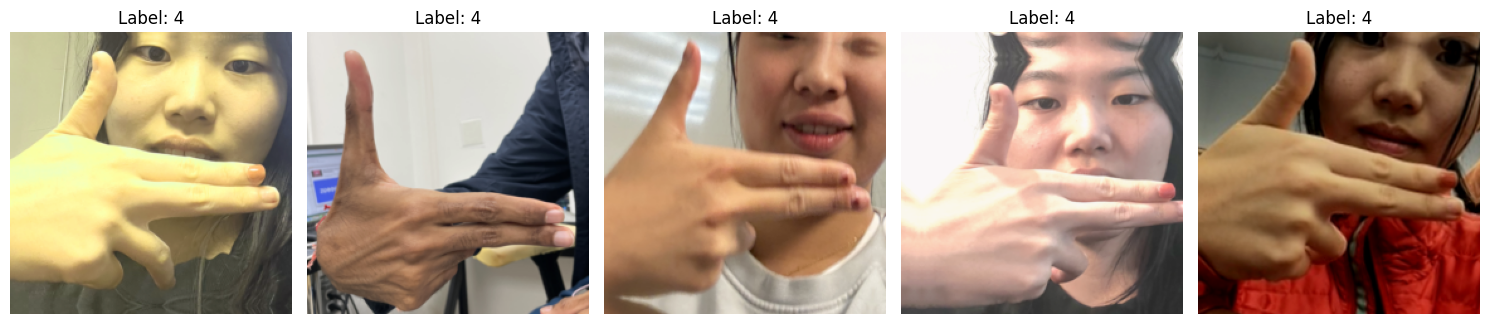

In [ ]:
def visualize_augmentations(dataset, num_samples=5):
    indices = random.sample(range(len(dataset)), num_samples) # Randomly select some of the photos
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    
    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        image = image.permute(1, 2, 0).numpy()
        image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406] 
        image = (image * 255).astype('uint8')

        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(f"Label: {label}")
    
    plt.tight_layout()
    plt.show()

visualize_augmentations(train_dataset, num_samples=5)
